# Preproccessing

### Download data

In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


### Format training data

In [37]:
import torch 
import os
import numpy as np
from PIL import Image

# Set the computation device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model.
# model = test_efficientnet_v2_s_model()

# Initialize the image preprocess.
# preprocess = transforms.Compose([
#         transforms.Resize((128, 128)),  # Resize the images to size x size
#         transforms.ToTensor()            # Convert the images to PyTorch tensors
#     ]) if train else models.EfficientNet_V2_S_Weights.DEFAULT.transforms()

data_list = []
label_list = []

for subdir, dirs, files in os.walk("./gdrive/MyDrive/imagenette2-160-1/train/"):
    for i, file in enumerate(files):
        # Open the image using Pillow library
        if i < 10000:
          img_path = os.path.join(subdir, file)
          img = Image.open(img_path)
          if img.mode == 'RGB':
            # Convert the image to a numpy array and add it to the data list
            # img_array = np.asarray(preprocess(img))
            img_array = np.asarray(img)
            data_list.append(img_array)
            
            # Get the label from the Directory name
            label = os.path.basename(subdir)
            # Add the label to the label list
            label_list.append(label)

# Convert the data list and label list to numpy arrays
data_array = np.array(data_list)
label_array = np.array(label_list)

print(np.shape(data_array))
print(np.shape(label_array))

(9325,)
(9325,)


<ipython-input-37-74dcb95c5589>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_array = np.array(data_list)


### Split into train and test set

In [38]:
import numpy as np
from sklearn.model_selection import train_test_split

def split_data(data, labels, test_size=0.2, random_state=42):
    """
    Splits the input data and labels arrays into a training and test set.

    Args:
    - data (numpy array): the input data array
    - labels (numpy array): the corresponding label array
    - test_size (float, optional): the proportion of the dataset to include in the test split (default=0.2)
    - random_state (int, optional): the seed used by the random number generator (default=42)

    Returns:
    - X_train (numpy array): the training data
    - X_test (numpy array): the test data
    - y_train (numpy array): the training labels
    - y_test (numpy array): the test labels
    """

    # Split the data and labels into a training and test set
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test

In [39]:
import torch
from torch.utils.data import TensorDataset
import numpy as np
from PIL import Image
from torchvision.transforms import transforms

def transform_dataset(X, y, size=32):
    """
    Transforms a list of numpy arrays containing images of different sizes into a PyTorch TensorDataset object.

    Args:
        X (list of numpy arrays): List of input images.
        y (list or numpy array): List or numpy array of corresponding labels.
        size (int): Size of the output images. Default is 32.

    Returns:
        TensorDataset: PyTorch TensorDataset object containing the transformed images and labels.
    """
    # Define a transformation pipeline to resize the images to a fixed size and convert them to tensors
    transform = transforms.Compose([
        transforms.Resize((size, size)),  # Resize the images to size x size
        transforms.ToTensor()            # Convert the images to PyTorch tensors
    ])

    # Define empty arrays to store the transformed images and labels
    X_transformed = []
    y_transformed = []

    # Loop over each image in X and apply the transformation pipeline
    for i in range(len(X)):
        # Convert the numpy array to a PIL image
        img = Image.fromarray(np.uint8(X[i]))

        # Apply the transformation pipeline to the image
        img_transformed = transform(img)

        # Append the transformed image and its corresponding label to the output arrays
        X_transformed.append(img_transformed)

    # Convert the labels to a NumPy array of integers
    classes = np.unique(y)
    y_transformed = np.searchsorted(classes, y)

    X_transformed_new = []
    y_transformed_new = []
    for i in range(len(X_transformed)):
      if(X_transformed[i].shape[0] == 3):
        X_transformed_new.append(X_transformed[i])
        y_transformed_new.append(y_transformed[i])
      else:
        print("Deleted:", i)

    # Convert the output arrays to PyTorch tensors
    X_transformed = torch.stack(X_transformed_new)
    y_transformed = torch.tensor(y_transformed_new)
 
    # Create a PyTorch TensorDataset object
    dataset = TensorDataset(X_transformed, y_transformed)

    return dataset


# Training Loop


In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import torchvision.models as models
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import ToTensor

from torchvision.models.efficientnet import FusedMBConvConfig,MBConvConfig,EfficientNet
from functools import partial

In [41]:
X_train, X_test, y_train, y_test = split_data(data_array, label_array)
num_classes = len(np.unique(y_train))
learning_rate = 0.0001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = transform_dataset(X_train, y_train)
test_dataset = transform_dataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [42]:
# default

inverted_residual_setting = [
    FusedMBConvConfig(1, 3, 1, 24, 24, 2),
    FusedMBConvConfig(4, 3, 2, 24, 48, 4),
    FusedMBConvConfig(4, 3, 2, 48, 64, 4),
    MBConvConfig(4, 3, 2, 64, 128, 6),
    MBConvConfig(6, 3, 1, 128, 160, 9),
    MBConvConfig(6, 3, 2, 160, 256, 15),
]

model_default = EfficientNet(inverted_residual_setting, 0.2, last_channel=1280, norm_layer=partial(nn.BatchNorm2d, eps=1e-03)).to(device)

In [43]:
# only using MBConv layers

inverted_residual_setting = [
    MBConvConfig(1, 3, 1, 24, 24, 2),
    MBConvConfig(4, 3, 2, 24, 48, 4),
    MBConvConfig(4, 3, 2, 48, 64, 4),
    MBConvConfig(4, 3, 2, 64, 128, 6),
    MBConvConfig(6, 3, 1, 128, 160, 9),
    MBConvConfig(6, 3, 2, 160, 256, 15),
]
model1 = EfficientNet(inverted_residual_setting, 0.2, last_channel=1280, norm_layer=partial(nn.BatchNorm2d, eps=1e-03)).to(device)

In [44]:
# only using FusedMBConv layers

inverted_residual_setting = [
    FusedMBConvConfig(1, 3, 1, 24, 24, 2),
    FusedMBConvConfig(4, 3, 2, 24, 48, 4),
    FusedMBConvConfig(4, 3, 2, 48, 64, 4),
    FusedMBConvConfig(4, 3, 2, 64, 128, 6),
    FusedMBConvConfig(6, 3, 1, 128, 160, 9),
    FusedMBConvConfig(6, 3, 2, 160, 256, 15),
]
model2 = EfficientNet(inverted_residual_setting, 0.2, last_channel=1280, norm_layer=partial(nn.BatchNorm2d, eps=1e-03)).to(device)

In [45]:
# half the number of layers

inverted_residual_setting = [
    FusedMBConvConfig(1, 3, 1, 24, 24, 1),
    FusedMBConvConfig(4, 3, 2, 24, 48, 2),
    FusedMBConvConfig(4, 3, 2, 48, 64, 2),
    MBConvConfig(4, 3, 2, 64, 128, 3),
    MBConvConfig(6, 3, 1, 128, 160, 4),
    MBConvConfig(6, 3, 2, 160, 256, 7),
]

model3 = EfficientNet(inverted_residual_setting, 0.2, last_channel=1280, norm_layer=partial(nn.BatchNorm2d, eps=1e-03)).to(device)

In [46]:
# dropped a config from recommmended


inverted_residual_setting = [
    FusedMBConvConfig(1, 3, 1, 24, 48, 2),
    FusedMBConvConfig(4, 3, 2, 48, 64, 4),
    MBConvConfig(4, 3, 2, 64, 128, 6),
    MBConvConfig(6, 3, 2, 128, 256, 15),
]

model4 = EfficientNet(inverted_residual_setting, 0.2, last_channel=1280, norm_layer=partial(nn.BatchNorm2d, eps=1e-03)).to(device)

In [47]:
ablation_models = [model_default, model1, model2, model3, model4]

In [48]:
results = [{"train":[], "test":[]} for m in ablation_models]

index = -1
for model in ablation_models:

  index += 1
  print("STARTING TRAINING FOR MODEL NUMBER", index)

  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  criterion = nn.CrossEntropyLoss()

  for epoch in range(100):
      # Training
      model.train()
      for i, (inputs, labels) in enumerate(train_loader):
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
      
      
      # Testing
      model.eval()
      correct = 0
      total = 0
      with torch.no_grad():
          for inputs, labels in train_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
      
      results[index]["train"].append(correct/total)

      print('Epoch: {}, Training Accuracy: {:.2f}%'.format(epoch+1, 100*correct/total))
      
      correct = 0
      total = 0
      with torch.no_grad():
          for inputs, labels in test_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
      
      results[index]["test"].append(correct/total)

      print('Epoch: {}, Test Accuracy: {:.2f}%'.format(epoch+1, 100*correct/total))

STARTING TRAINING FOR MODEL NUMBER 0
Epoch: 1, Training Accuracy: 10.12%
Epoch: 1, Test Accuracy: 10.24%
Epoch: 2, Training Accuracy: 17.17%
Epoch: 2, Test Accuracy: 17.53%
Epoch: 3, Training Accuracy: 22.18%
Epoch: 3, Test Accuracy: 21.61%
Epoch: 4, Training Accuracy: 24.50%
Epoch: 4, Test Accuracy: 23.27%
Epoch: 5, Training Accuracy: 28.55%
Epoch: 5, Test Accuracy: 26.76%
Epoch: 6, Training Accuracy: 29.02%
Epoch: 6, Test Accuracy: 25.68%
Epoch: 7, Training Accuracy: 31.51%
Epoch: 7, Test Accuracy: 29.65%
Epoch: 8, Training Accuracy: 35.67%
Epoch: 8, Test Accuracy: 32.82%
Epoch: 9, Training Accuracy: 38.97%
Epoch: 9, Test Accuracy: 35.28%
Epoch: 10, Training Accuracy: 43.77%
Epoch: 10, Test Accuracy: 38.02%
Epoch: 11, Training Accuracy: 46.77%
Epoch: 11, Test Accuracy: 38.07%
Epoch: 12, Training Accuracy: 50.68%
Epoch: 12, Test Accuracy: 41.13%
Epoch: 13, Training Accuracy: 54.83%
Epoch: 13, Test Accuracy: 41.45%
Epoch: 14, Training Accuracy: 58.79%
Epoch: 14, Test Accuracy: 43.06%
E

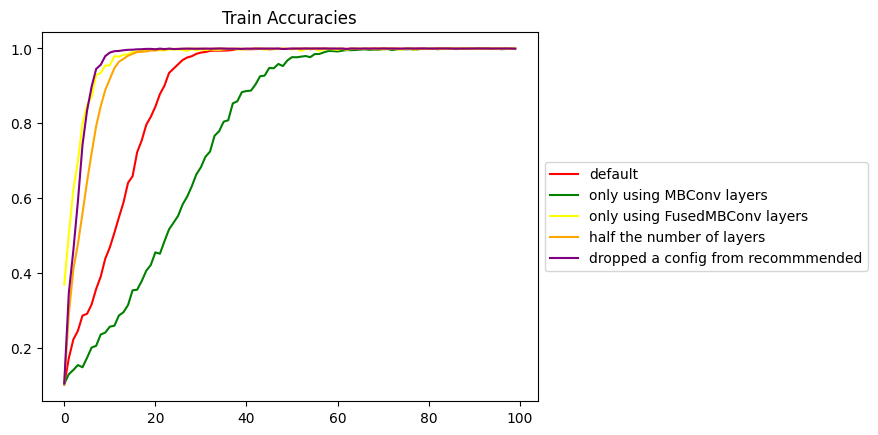

In [49]:
import numpy as np
import matplotlib.pyplot as plt

x = list(range(len(results[0]["train"])))

plt.plot(x, results[0]["train"], color='red', label='default')
plt.plot(x, results[1]["train"], color='green', label='only using MBConv layers')
plt.plot(x, results[2]["train"], color='yellow', label='only using FusedMBConv layers')
plt.plot(x, results[3]["train"], color='orange', label='half the number of layers')
plt.plot(x, results[4]["train"], color='purple', label='dropped a config from recommmended')

plt.title('Train Accuracies')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

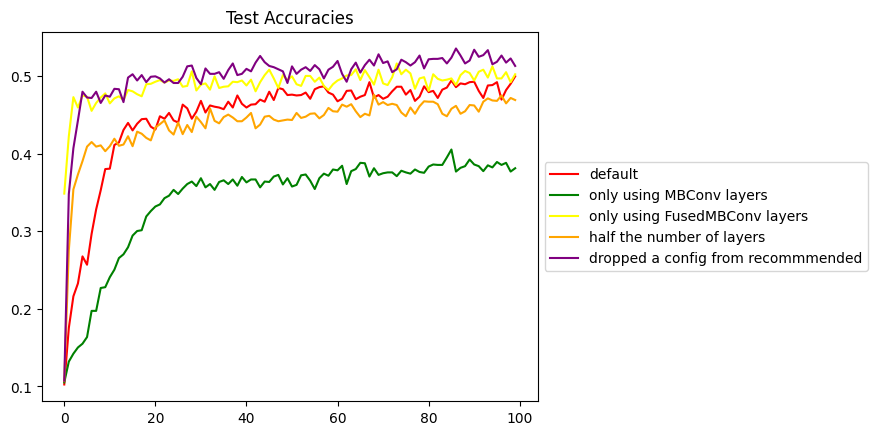

In [50]:
x = list(range(len(results[0]["test"])))

plt.plot(x, results[0]["test"], color='red', label='default')
plt.plot(x, results[1]["test"], color='green', label='only using MBConv layers')
plt.plot(x, results[2]["test"], color='yellow', label='only using FusedMBConv layers')
plt.plot(x, results[3]["test"], color='orange', label='half the number of layers')
plt.plot(x, results[4]["test"], color='purple', label='dropped a config from recommmended')

plt.title('Test Accuracies')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()